# Title: Effects of Atlantic Niño on Hurricane Genesis Potential

## Questions:
    What is the relationship between Atlantic Niño and Hurricane genesis?
    
    Bjerkness feedback and hurricane generation?
    
    Is there an effect of model biases on this relationship, specifically CMIP and E3M?
    
    Do the large ensembles correlate with reanalysis correlations?
    
    (future work?) Are future changes in Bjerkness feedback and atmosphere ocean decoupling causing changes in hurricane genesis potential?
    
    (future work) 


<h1>Notes:</h1>
    Atlantic Niño (AN) is a seasonal phenomenon which during its positive phase raises SSTs in the eastern equatorial Atlantic near the African coasts, relaxes trade winds, and weakens east-west SST gradient (Fasullo et al X).   
   

# Tasks and required I/O

## Task 1: Reanalysis Time series

IN: HadiSST Netcdf

OUT: Time series of average SST in the box. from 3S to 3N 0W to 20W

## Task 2: Reanalysis Atlantic Niño index

IN: SST dataframe

OUT: Weighted average based anomaly time series

## Task 3: Atlantic Niño JJA Composite maps

IN: Atlantic Niño index dataframe

OUT: JJA area weighted mean anomaly 20S to 20N and 100W to 20E

# Necessary Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import metpy
import cftime
from geocat.viz import util as gvutil
import warnings
import xesmf as xe
# from geocat.viz import cmaps as gvcmaps
# import tcpypi must upload package

# Useful Functions

In [3]:
def COORDS_box(ds, box=None):
    # if box == None:
    #     # Bounding Box in degN and degE
    #     north = 3
    #     south = -3
    #     east = 360
    #     west = 340
    # else:
    # custom bounding box
    west, east, south, north = box
    t_i = cftime.DatetimeNoLeap(1870, 1, 15)
    t_f = cftime.DatetimeNoLeap(2024, 12, 31)
    return ds.sel(latitude=slice(south, north), longitude=slice(west, east),
                  time=slice(t_i, t_f))

    # corrected = False
    # if west < 0:
    #     west += 360
    #     corrected = True
    # if east < 0:
    #     east += 360
    #     corrected = True
    # if east < west:
    #     ds = ds.where(((ds.longitude > west) | (ds.longitude < east)))
    # if south < 0:
    #     ds = ds.where(((ds.latitude > south) | (ds.latitude < north)))

    # else:
    #     return ds.sel(latitude=slice(south, north), longitude=slice(west, east), time=slice(t_i, t_f))


def AN_map(ds_to_plt, bounds, name):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.longitude)

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)

    def resize_colobar(event):
        plt.draw()
        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, ds_to_plt.latitude, cdat, levels=20, transform=ccrs.PlateCarree(), cmap='YlOrBr')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    resize_colobar(None)
    plt.savefig(name, dpi=300)
    plt.show()


def cyclic_dataarray(da, coord='lon'):
    """ Add a cyclic coordinate point to a DataArray along a specified
    named coordinate dimension.

    >>> from xray import DataArray
    >>> data = DataArray([[1, 2, 3], [4, 5, 6]],
    ...                      coords={'x': [1, 2], 'y': range(3)},
    ...                      dims=['x', 'y'])
    >>> cd = cyclic_dataarray(data, 'y')
    >>> print cd.data
    array([[1, 2, 3, 1],
           [4, 5, 6, 4]])
    """
    assert isinstance(da, xr.DataArray)

    lon_idx = da.dims.index(coord)
    cyclic_data, cyclic_coord = cutil.add_cyclic_point(da.values,
                                                 coord=da.coords[coord],
                                                 axis=lon_idx)

    # Copy and add the cyclic coordinate and data
    new_coords = dict(da.coords)
    new_coords[coord] = cyclic_coord
    new_values = cyclic_data

    new_da = xr.DataArray(new_values, dims=da.dims, coords=new_coords)

    # Copy the attributes for the re-constructed data and coords
    for att, val in da.attrs.items():
        new_da.attrs[att] = val
    for c in da.coords:
        for att in da.coords[c].attrs:
            new_da.coords[c].attrs[att] = da.coords[c].attrs[att]

    return new_da

# HadiSST Atlantic Niño index

## Data Import

In [4]:
# import data into xarray
ds = xr.open_dataset('/glade/campaign/collections/rda/data/d277003/HadISST_sst.nc.gz') 
# print(ds.keys())

In [5]:
ds

<xarray.Dataset>
Dimensions:    (time: 1861, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 1870-01-16T11:59:59.505615234 ... 2025-0...
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    3/3/2025 converted to netcdf from pp format
    supplementary_information:  Updates and supplementary information will be...
    comment:                    Data restrictions: for academic research use ...

## Mean SST in AN box

In [6]:
# change time format to cftime for easier indexing
obs_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 1) for year in range(156) for month in range(12)]
ds['time'] = obs_montime_vals[:][:-11]

In [7]:
# select data
sst = ds.sst
boxed_SST = COORDS_box(sst, box=(-20, 0, 3, -3))

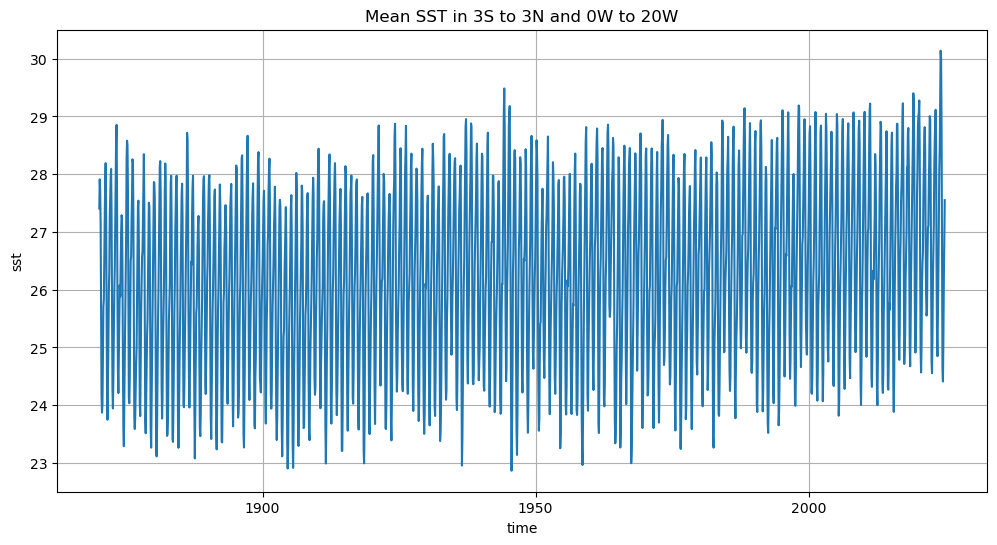

In [8]:
# get weight of latitudes
area_weight = np.cos(np.deg2rad(ds.latitude))
area_weight.name = "weights"

# weight SSTs
weighted_sst = boxed_SST.weighted(area_weight)

# calculate mean SST in the area
sst_mean = weighted_sst.mean(("longitude", "latitude"))

sst_mean.plot(figsize=(12, 6))
# sst_mean = sst_mean.where(sst_mean['time.season']=='JJA')

plt.title("Mean SST in 3S to 3N and 0W to 20W")
plt.grid()
plt.show()

## Climatologies, anomalies, and index

In [12]:
# calculate monthly climatologies
climatology = boxed_SST.groupby("time.month").mean()

# calculate monthly anomalies
sst_anom_month = boxed_SST.groupby("time.month") - climatology

In [13]:
# running mean for every three months
ATLN_Index = sst_anom_month.rolling(time=3, center=True).mean()
ATLN_weighted = ATLN_Index.weighted(area_weight).mean(("latitude", "longitude"), skipna=True)

## Atlantic Niño Index

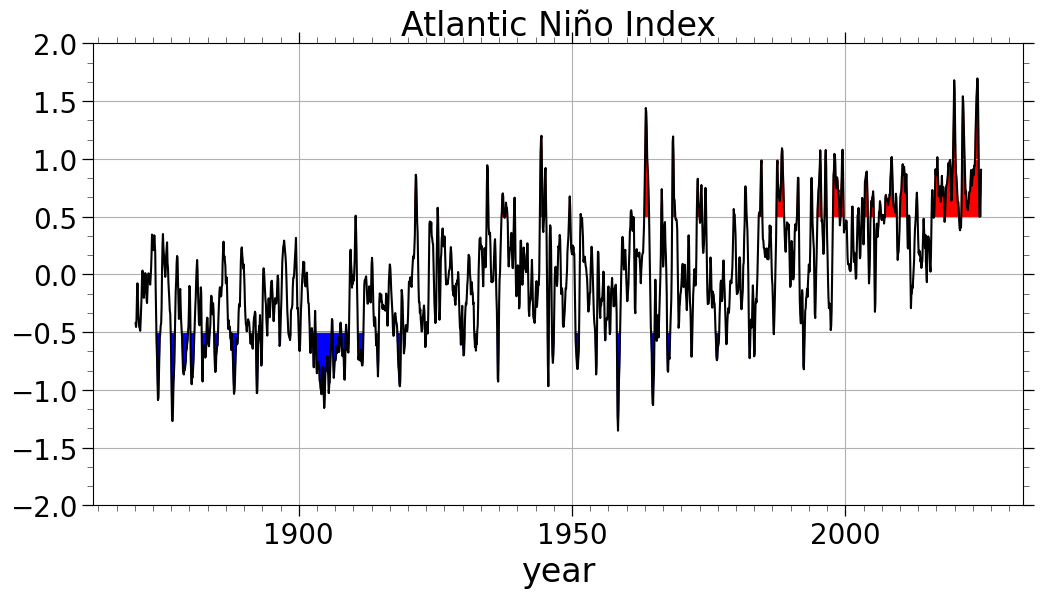

In [14]:
# atlantic niño index plot
fig,ax = plt.subplots(figsize=(12,6))

threshold = 0.5

ax.plot(ATLN_weighted.time, ATLN_weighted, color='black')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-2., 2.))
ax.fill_between(ATLN_weighted.time.values, ATLN_weighted , y2= -threshold, where=ATLN_weighted < -threshold, color='blue', interpolate=True)
ax.fill_between(ATLN_weighted.time.values, ATLN_weighted, y2= threshold, where=ATLN_weighted > threshold, color='red', interpolate=True)

ax.set_title('Atlantic Niño Index', fontsize=24)#, pad=60.0)
# ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)
plt.grid()
plt.savefig('Atlantic Niño Index', dpi=300)
plt.show()

## JJA Map

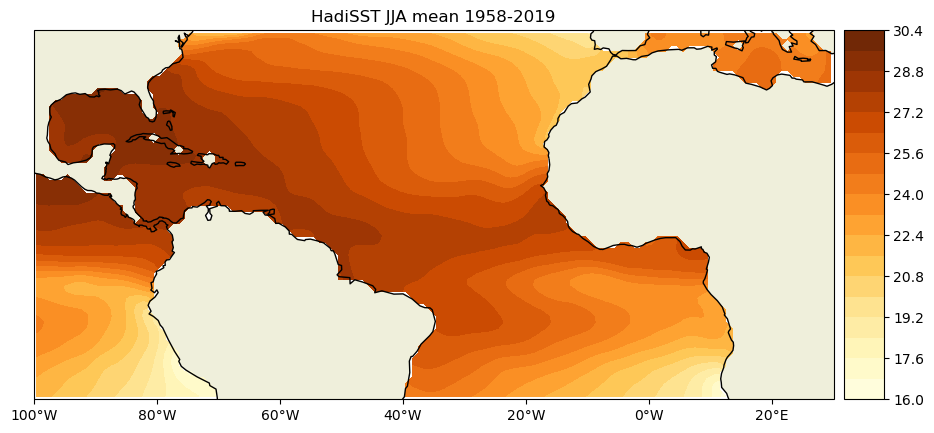

In [15]:
# Select data on map range
box = (-100, 30, 40, -20)
SST_boxed = COORDS_box(sst, box)

# select JJA
JJA_SST = SST_boxed.where(SST_boxed['time.season']=='JJA', drop=True)

# climatology
JJA_clim = JJA_SST.mean('time')

# plot
AN_map(JJA_clim, box, "HadiSST JJA mean 1958-2019")

In [16]:
# # interpolate to 1.25 to match JRA55 dataset
# lons = np.arange(-1.25, 360, 1.25)
# lats = np.arange(-90, 90, 1.25)
# SST_125 = SST.interp(coords={'lon': lons, 'lat': lats})

# # select sst for the whole box (if its weird change this to just default ATLN box)
# box = (-100, 20, -20, 40)
# boxed_SST = ATLN_box(SST_125, box)

# # do climatologies
# climatology2 = boxed_SST.groupby("time.month").mean(skipna=True)

# # get anomalies
# SST_anom = boxed_SST.groupby("time.month") - climatology2

# # get 3 month running mean of anomalies
# anom_rmean = SST_anom.rolling(time=3, center=True).mean(skipna=True)
# anom_alltime = anom_rmean.mean("time")

# # get ATLN+ frequency
# # 1. count ATLN+ months
# ATLN_p = xr.where(anom_rmean >= 0.5, 1, 0)
# ATLN_py = ATLN_p.sum('time')

# # 2. divide by number of months in dataset
# ATLN_freq = ATLN_py / len(ATLN_p.time)
# # plot composite grays filled with ATLN+ and colored lines with values for each month
# map_box = (-100, 0, -0, 40)
# AN_map(ATLN_freq, box, "ATLN+ frequency from HadiSST 1958-2019")

In [17]:
# AN_map(anom_alltime, box, "HadiSST mean anomalies 1958-2019")

# ATLN+ phases

In [18]:
sst

<xarray.DataArray 'sst' (time: 1861, latitude: 180, longitude: 360)>
[120592800 values with dtype=float32]
Coordinates:
  * time       (time) object 1870-01-01 00:00:00 ... 2025-01-01 00:00:00
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [19]:
# interpolate to 1.25 to match JRA55 dataset
grid = 1.25
lons = np.arange(-180, 180, grid)
lats = np.arange(-90, 90, grid)

# grid_in = {"longitude": sst.longitude.values, "latitude": sst.latitude.values}
grid_out = {"lon": lons, "lat": lats}


regridder = xe.Regridder(sst, grid_out, "bilinear", periodic=True)
regridder  # print basic regridder information.

/glade/u/apps/opt/conda/envs/npl-2023a/lib/python3.9/site-packages/xarray/core/dataarray.py:866: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_180x360_144x288_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (180, 360) 
Output grid shape:          (144, 288) 
Periodic in longitude?      True

In [20]:
SST_inted = regridder(sst)
SST_inted = SST_inted.rename({"lat": "latitude", "lon": "longitude"})

In [21]:
# find ATLN phase years
ATLN_Index_JJA = ATLN_Index.where(ATLN_Index['time.season'] == 'JJA')
ATLN_weighted = ATLN_Index_JJA.weighted(area_weight).mean(("latitude", "longitude"))
ATLNp_years = ATLN_weighted_JJA.where(ATLN_weighted_JJA >= 0.5, drop=True).time.dt.year.values
ATLNn_years = ATLN_weighted_JJA.where(ATLN_weighted_JJA <= 0.5, drop=True).time.dt.year

NameError: name 'ATLN_weighted_JJA' is not defined

In [ ]:
ATLN_p = np.unique(ATLNp_years)

In [ ]:
ATLN_n = np.unique(ATLNn_years)

# Export results

In [ ]:
np.savetxt("Results/ATLN+.csv", ATLN_p, delimiter=',', fmt='%f')

In [ ]:
np.savetxt("Results/ATLN-.csv", ATLN_n, delimiter=',',fmt='%f')